In [1]:
!pip uninstall tensorflow-datasets tensorflow-metadata -y
!pip install tensorflow==2.11
!pip install sciann

1.1. Ajuste de la curva $y = sin(x)$ en el intervalo $[0,2\pi]$.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D10b_4 (Dense)              (None, 10)                20        
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               14        
 3 (SciRowdyActivationLayer)                                     
                                                                 
 D10b_5 (Dense)              (None, 10)                110       
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               14        
 4 (SciRowdyActivationLayer)                                     
                                                                 
 D10b_6 (Dense)              (None, 10)                110 

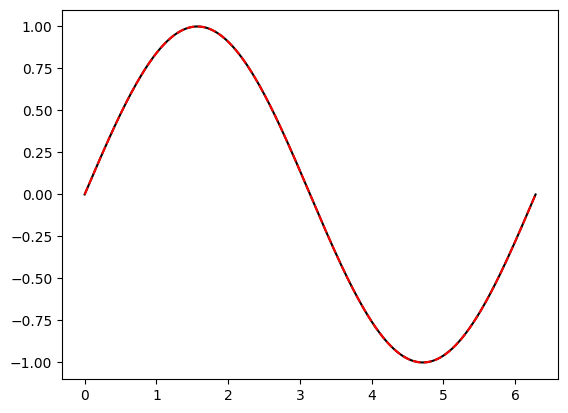

In [3]:
import numpy as np
from sciann import Variable, Functional, SciModel
from sciann.constraints import Data
import sciann as sn
import time


# Generación de datos sintéticos.
x_true = np.linspace(0, np.pi*2, 10000)
y_true = np.sin(x_true)
dy_true = np.cos(x_true)

# Definimos la estructura de la función que queremos aprender.
x = Variable('x')
xf = Functional('xf', x)
xf.set_trainable(False)


y = Functional('y', x, [10, 10, 10], activation=['tanh', 'g-cos', 'l-sin'])
dy_dx = sn.diff(y, x)



# Imponemos restricciones al modelo.
c1 = Data(y)

# Definimos el modelo.
model = SciModel(x, [y, dy_dx], optimizer='adam')
model.summary()

start_time = time.time()

# Entrenamiento.
model.train(x_true,
            [y_true, dy_true],
            epochs=200,
            learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-3,
                           "final_learning_rate": 1e-5,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            # adaptive_weights={'method': "SASW", "eta": 0.1, "d_mask_func": lambda x: np.exp(x)},
            adaptive_weights={'method': "CLW", 'initial_weights': [0.1, 1.], 'final_weights': [2., 3.], 'curriculum_epochs': 20, "delay_epochs": 10},
            save_weights={'path': 'test', 'freq': 100}
            )

print(f"Training finished in {time.time()-start_time}s. ")

# Predicción
y_pred = y.eval(model, x_true)

# Mostramos los resultados
import matplotlib.pyplot as plt
plt.plot(x_true, y_true, '-k', x_true, y_pred, '--r')
plt.show()

1.2. Ajuste de la curva $y = exp(x)$ en el intervalo $[0,1]$.

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D10b_16 (Dense)             (None, 10)                20        
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               3         
 15 (SciRowdyActivationLayer                                     
 )                                                               
                                                                 
 D10b_17 (Dense)             (None, 10)                110       
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               3         
 16 (SciRowdyActivationLayer                                     
 )                                                         

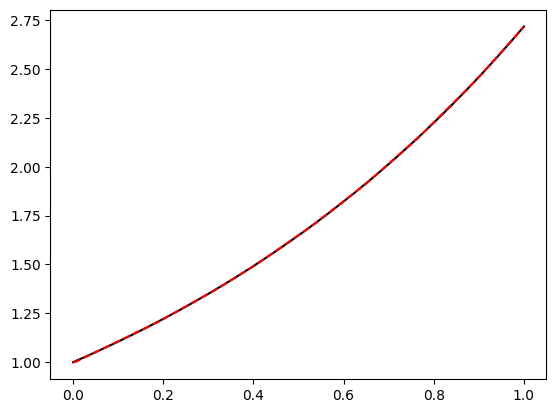

In [8]:
import numpy as np
from sciann import Variable, Functional, SciModel
from sciann.constraints import Data
from tensorflow import keras
import sciann as sn
import time


# Generación de datos sintéticos.
x_true = np.linspace(0, 1, 10000)
y_true = np.exp(x_true)
dy_true = np.exp(x_true)

# Definimos la estructura de la función que queremos aprender.
x = Variable('x')
xf = Functional('xf', x)


y = Functional('y', x, [10, 10, 10], activation=['relu', 'relu', 'relu'])


# Imponemos restricciones al modelo.

dy_dx = sn.diff(y, x)
c1 = Data(y)

# Definimos el modelo.
model = SciModel(x, [y, dy_dx], optimizer='adam')
model.summary()

start_time = time.time()

# Entrenamiento.
model.train(x_true,
            [y_true, dy_true],
            epochs=1000,
            learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-3,
                           "final_learning_rate": 1e-5,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            callbacks=[keras.callbacks.EarlyStopping(monitor="y_loss", min_delta = 0, patience=5,verbose=1)]
            )

print(f"Training finished in {time.time()-start_time}s. ")

# Predicción.
y_pred = y.eval(model, x_true)

# Mostramos los resultados.
import matplotlib.pyplot as plt
plt.plot(x_true, y_true, '-k', x_true, y_pred, '--r')
plt.show()